## 기본 베이지 DNN

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
%matplotlib inline

path = "./optimal_data"
file_list = os.listdir(path)



In [9]:
%matplotlib inline

In [10]:
df=pd.read_excel('./optimal_data/'+'Continous_2weeks_28day_8term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

smote = SMOTE(random_state=0)
X_over,y_over = smote.fit_resample(X,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over.shape, y_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series( y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (2576, 6) (2576,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (5142, 6) (5142,)
SMOTE 적용 전 레이블 값 분포: 
 0    1714
1     512
2     350
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    1714
1    1714
2    1714
Name: 8, dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
#     X_train=X.iloc[:3375,:]
#     X_test=X.iloc[3375:,:]

#     y_train=y.iloc[:3375]
#     y_test=y.iloc[3375:]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test.to_numpy())

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16,shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16,shuffle=False)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
X

1     3    4    5    6      7
0     45.0  72.0  0.0  0.0  0.0  148.0
1     45.0  72.0  0.0  0.0  0.0  148.0
2     45.0  72.0  0.0  0.0  0.0  148.0
3     45.0  72.0  0.0  0.0  0.0  148.0
4     45.0  72.0  0.0  0.0  0.0  148.0
...    ...   ...  ...  ...  ...    ...
2571  68.0   0.0  0.0  0.0  0.0  153.0
2572  68.0   0.0  0.0  0.0  0.0  153.0
2573  68.0   0.0  0.0  0.0  0.0  153.0
2574  68.0   0.0  0.0  0.0  0.0  153.0
2575  68.0   0.0  0.0  0.0  0.0  153.0

[2576 rows x 6 columns]

In [15]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [16]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [17]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [18]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [19]:
# 최대 Epoch을 지정합니다.
num_epochs = 500
max_acc = 0
loss_list=[]
acc_list=[]
# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)
    
    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_acc > max_acc:
        print(f'[INFO] val_acc has been improved from {max_acc:.5f} to {val_acc:.5f}. Saving Model!')
        max_acc = val_acc
        torch.save(model.state_dict(), 'DNNModel.pth')

    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
    loss_list.append(train_loss)
    acc_list.append(train_acc)
## 저장한 가중치 로드 후 검증 성능 측정

# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc, pred_list = model_test(model, test_dataloader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 576.39it/s]


[INFO] val_acc has been improved from 0.00000 to 0.69470. Saving Model!
epoch 01, loss: 0.79435, acc: 0.66112, val_loss: 0.69621, val_accuracy: 0.69470


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.27it/s]

[INFO] val_acc has been improved from 0.69470 to 0.70375. Saving Model!


epoch 02, loss: 0.74164, acc: 0.67221, val_loss: 0.68598, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


[INFO] val_acc has been improved from 0.70375 to 0.70763. Saving Model!
epoch 03, loss: 0.72782, acc: 0.67998, val_loss: 0.68465, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.65it/s]


epoch 04, loss: 0.71862, acc: 0.68497, val_loss: 0.68314, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 582.34it/s]


epoch 05, loss: 0.70985, acc: 0.69218, val_loss: 0.68465, val_accuracy: 0.70116


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


epoch 06, loss: 0.70271, acc: 0.69329, val_loss: 0.68314, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 07, loss: 0.69450, acc: 0.69828, val_loss: 0.67972, val_accuracy: 0.70116


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 582.35it/s]


epoch 08, loss: 0.68675, acc: 0.70383, val_loss: 0.68256, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


epoch 09, loss: 0.68030, acc: 0.70882, val_loss: 0.68124, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 579.36it/s]


epoch 10, loss: 0.67232, acc: 0.70605, val_loss: 0.68176, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 585.36it/s]


epoch 11, loss: 0.66447, acc: 0.70826, val_loss: 0.67586, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 594.61it/s]


epoch 12, loss: 0.65746, acc: 0.71547, val_loss: 0.67539, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 594.60it/s]


epoch 13, loss: 0.64938, acc: 0.72047, val_loss: 0.67535, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 567.71it/s]


[INFO] val_acc has been improved from 0.70763 to 0.71022. Saving Model!
epoch 14, loss: 0.64184, acc: 0.71936, val_loss: 0.67178, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


[INFO] val_acc has been improved from 0.71022 to 0.71281. Saving Model!
epoch 15, loss: 0.63551, acc: 0.72047, val_loss: 0.67007, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 16, loss: 0.62883, acc: 0.72102, val_loss: 0.66856, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


[INFO] val_acc has been improved from 0.71281 to 0.71798. Saving Model!
epoch 17, loss: 0.62282, acc: 0.72268, val_loss: 0.67098, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 567.71it/s]


epoch 18, loss: 0.61762, acc: 0.72657, val_loss: 0.67124, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


[INFO] val_acc has been improved from 0.71798 to 0.71928. Saving Model!
epoch 19, loss: 0.61133, acc: 0.72934, val_loss: 0.67191, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 576.40it/s]


[INFO] val_acc has been improved from 0.71928 to 0.72574. Saving Model!
epoch 20, loss: 0.60546, acc: 0.73267, val_loss: 0.67137, val_accuracy: 0.72574


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 21, loss: 0.60098, acc: 0.73710, val_loss: 0.67229, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 585.36it/s]


epoch 22, loss: 0.59669, acc: 0.73877, val_loss: 0.67891, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 588.41it/s]


epoch 23, loss: 0.59259, acc: 0.74598, val_loss: 0.68353, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 588.41it/s]


epoch 24, loss: 0.58787, acc: 0.74598, val_loss: 0.68499, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 588.41it/s]


epoch 25, loss: 0.58365, acc: 0.74653, val_loss: 0.69169, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 588.41it/s]


epoch 26, loss: 0.57948, acc: 0.74542, val_loss: 0.69587, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 576.40it/s]


epoch 27, loss: 0.57478, acc: 0.74709, val_loss: 0.69416, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.32it/s]


epoch 28, loss: 0.57048, acc: 0.75097, val_loss: 0.69596, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 537.97it/s]


epoch 29, loss: 0.56644, acc: 0.75042, val_loss: 0.69957, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 30, loss: 0.56197, acc: 0.75263, val_loss: 0.69962, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 579.36it/s]


epoch 31, loss: 0.55935, acc: 0.75485, val_loss: 0.70143, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 32, loss: 0.55551, acc: 0.75319, val_loss: 0.70902, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 33, loss: 0.54915, acc: 0.75818, val_loss: 0.70771, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 34, loss: 0.54777, acc: 0.76040, val_loss: 0.71210, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 35, loss: 0.54318, acc: 0.76373, val_loss: 0.71059, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.15it/s]


epoch 36, loss: 0.53974, acc: 0.76095, val_loss: 0.72049, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 37, loss: 0.53484, acc: 0.76428, val_loss: 0.71820, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 38, loss: 0.53243, acc: 0.76761, val_loss: 0.71854, val_accuracy: 0.72445


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 39, loss: 0.52918, acc: 0.76872, val_loss: 0.72744, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 40, loss: 0.52652, acc: 0.77260, val_loss: 0.72666, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.15it/s]


epoch 41, loss: 0.52095, acc: 0.77260, val_loss: 0.74188, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.68it/s]


epoch 42, loss: 0.51934, acc: 0.77038, val_loss: 0.73618, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 43, loss: 0.51479, acc: 0.77149, val_loss: 0.73508, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 44, loss: 0.51328, acc: 0.77482, val_loss: 0.74539, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.91it/s]


epoch 45, loss: 0.51091, acc: 0.77038, val_loss: 0.75883, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 46, loss: 0.50979, acc: 0.77482, val_loss: 0.74139, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 47, loss: 0.50394, acc: 0.77593, val_loss: 0.74693, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 48, loss: 0.50169, acc: 0.77149, val_loss: 0.74642, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 548.42it/s]


epoch 49, loss: 0.49894, acc: 0.78037, val_loss: 0.75357, val_accuracy: 0.72316


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 50, loss: 0.49480, acc: 0.78314, val_loss: 0.75959, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 553.83it/s]


epoch 51, loss: 0.48997, acc: 0.78647, val_loss: 0.76332, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 463.01it/s]


epoch 52, loss: 0.49256, acc: 0.77815, val_loss: 0.77579, val_accuracy: 0.72316


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.66it/s]


[INFO] val_acc has been improved from 0.72574 to 0.72833. Saving Model!
epoch 53, loss: 0.48622, acc: 0.78369, val_loss: 0.77794, val_accuracy: 0.72833


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 54, loss: 0.48712, acc: 0.77981, val_loss: 0.78966, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 55, loss: 0.48023, acc: 0.78314, val_loss: 0.79120, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 56, loss: 0.47936, acc: 0.78425, val_loss: 0.80751, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.15it/s]


epoch 57, loss: 0.47554, acc: 0.78702, val_loss: 0.81063, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 58, loss: 0.47341, acc: 0.78979, val_loss: 0.79342, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 59, loss: 0.46908, acc: 0.79035, val_loss: 0.80245, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 60, loss: 0.46854, acc: 0.79090, val_loss: 0.79718, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.34it/s]


epoch 61, loss: 0.46630, acc: 0.79534, val_loss: 0.81090, val_accuracy: 0.72316


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 62, loss: 0.46401, acc: 0.79534, val_loss: 0.82470, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 63, loss: 0.46154, acc: 0.79534, val_loss: 0.81257, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 64, loss: 0.45898, acc: 0.79867, val_loss: 0.85521, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 65, loss: 0.46251, acc: 0.78924, val_loss: 0.83652, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 66, loss: 0.45719, acc: 0.79534, val_loss: 0.84760, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 67, loss: 0.45377, acc: 0.79257, val_loss: 0.85277, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 68, loss: 0.45380, acc: 0.79090, val_loss: 0.86407, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 69, loss: 0.45171, acc: 0.79201, val_loss: 0.86090, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 70, loss: 0.44513, acc: 0.79423, val_loss: 0.87710, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 71, loss: 0.44471, acc: 0.79590, val_loss: 0.88523, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 72, loss: 0.44168, acc: 0.80200, val_loss: 0.87757, val_accuracy: 0.69858


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 73, loss: 0.44011, acc: 0.80200, val_loss: 0.89375, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]

epoch 74, loss: 0.43710, acc: 0.80144, val_loss: 0.90016, val_accuracy: 0.70116



100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 75, loss: 0.43595, acc: 0.79867, val_loss: 0.92698, val_accuracy: 0.70246


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 76, loss: 0.43702, acc: 0.80366, val_loss: 0.92363, val_accuracy: 0.69858


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 77, loss: 0.43204, acc: 0.80699, val_loss: 0.91596, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 78, loss: 0.42912, acc: 0.80255, val_loss: 0.92110, val_accuracy: 0.69728


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 79, loss: 0.42892, acc: 0.80200, val_loss: 0.93239, val_accuracy: 0.70116


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 80, loss: 0.42934, acc: 0.80366, val_loss: 0.94799, val_accuracy: 0.70246


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.15it/s]


epoch 81, loss: 0.42694, acc: 0.80311, val_loss: 0.95150, val_accuracy: 0.69470


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 623.59it/s]


epoch 82, loss: 0.42327, acc: 0.80643, val_loss: 0.95387, val_accuracy: 0.69728


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 83, loss: 0.42482, acc: 0.80588, val_loss: 0.95699, val_accuracy: 0.69470


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 84, loss: 0.42095, acc: 0.80422, val_loss: 0.95727, val_accuracy: 0.69987


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 85, loss: 0.42166, acc: 0.80921, val_loss: 0.96187, val_accuracy: 0.69599


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 86, loss: 0.42131, acc: 0.80422, val_loss: 0.97448, val_accuracy: 0.69987


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 87, loss: 0.41677, acc: 0.80699, val_loss: 0.97286, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 88, loss: 0.41404, acc: 0.81032, val_loss: 0.99789, val_accuracy: 0.69211


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 89, loss: 0.41575, acc: 0.80976, val_loss: 1.01010, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 90, loss: 0.42106, acc: 0.80754, val_loss: 1.02468, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 91, loss: 0.41732, acc: 0.80754, val_loss: 0.99963, val_accuracy: 0.69470


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 92, loss: 0.41477, acc: 0.81032, val_loss: 1.01128, val_accuracy: 0.69728


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 93, loss: 0.41554, acc: 0.81364, val_loss: 1.03158, val_accuracy: 0.69599


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 94, loss: 0.41416, acc: 0.81253, val_loss: 1.03878, val_accuracy: 0.69340


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 95, loss: 0.41042, acc: 0.81697, val_loss: 1.04094, val_accuracy: 0.69340


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.72it/s]


epoch 96, loss: 0.41397, acc: 0.81253, val_loss: 1.03775, val_accuracy: 0.69728


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 97, loss: 0.41127, acc: 0.81531, val_loss: 1.00867, val_accuracy: 0.68952


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 98, loss: 0.41352, acc: 0.81198, val_loss: 1.03761, val_accuracy: 0.69470


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 99, loss: 0.41118, acc: 0.81253, val_loss: 1.03302, val_accuracy: 0.69082


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]

epoch 100, loss: 0.40953, acc: 0.81198, val_loss: 1.05679, val_accuracy: 0.69211



100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 101, loss: 0.40847, acc: 0.81309, val_loss: 1.03378, val_accuracy: 0.69082


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.14it/s]


epoch 102, loss: 0.40895, acc: 0.81364, val_loss: 1.05818, val_accuracy: 0.69082


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.27it/s]


epoch 103, loss: 0.40529, acc: 0.81808, val_loss: 1.08828, val_accuracy: 0.69340


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 104, loss: 0.40358, acc: 0.81364, val_loss: 1.07569, val_accuracy: 0.69470


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 105, loss: 0.40591, acc: 0.81475, val_loss: 1.04409, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 106, loss: 0.40182, acc: 0.82085, val_loss: 1.07872, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 107, loss: 0.40448, acc: 0.81642, val_loss: 1.04958, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 108, loss: 0.39963, acc: 0.82030, val_loss: 1.07859, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 109, loss: 0.40179, acc: 0.81808, val_loss: 1.08880, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 110, loss: 0.39797, acc: 0.81586, val_loss: 1.06435, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 111, loss: 0.39826, acc: 0.81808, val_loss: 1.05964, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 112, loss: 0.39219, acc: 0.81919, val_loss: 1.07198, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 113, loss: 0.39452, acc: 0.81919, val_loss: 1.07587, val_accuracy: 0.70246


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 114, loss: 0.38966, acc: 0.81475, val_loss: 1.09663, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 115, loss: 0.38917, acc: 0.82252, val_loss: 1.08399, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 116, loss: 0.39008, acc: 0.81974, val_loss: 1.06786, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 117, loss: 0.38816, acc: 0.81697, val_loss: 1.09543, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 118, loss: 0.38700, acc: 0.82696, val_loss: 1.07930, val_accuracy: 0.70246


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 119, loss: 0.39084, acc: 0.82141, val_loss: 1.08357, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 120, loss: 0.38527, acc: 0.81919, val_loss: 1.09299, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 121, loss: 0.38574, acc: 0.82141, val_loss: 1.09615, val_accuracy: 0.70246


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 122, loss: 0.38361, acc: 0.82751, val_loss: 1.09972, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 123, loss: 0.38288, acc: 0.82529, val_loss: 1.08561, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.33it/s]


epoch 124, loss: 0.38704, acc: 0.82474, val_loss: 1.10188, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 125, loss: 0.39406, acc: 0.81309, val_loss: 1.09414, val_accuracy: 0.69987


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 126, loss: 0.38500, acc: 0.82141, val_loss: 1.08135, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 595.08it/s]


epoch 127, loss: 0.38487, acc: 0.82363, val_loss: 1.06506, val_accuracy: 0.69858


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 128, loss: 0.38528, acc: 0.82196, val_loss: 1.08955, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.75it/s]


epoch 129, loss: 0.37964, acc: 0.82252, val_loss: 1.10352, val_accuracy: 0.70116


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 629.41it/s]


epoch 130, loss: 0.37710, acc: 0.82640, val_loss: 1.09498, val_accuracy: 0.69987


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 131, loss: 0.37684, acc: 0.82363, val_loss: 1.09448, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 132, loss: 0.38227, acc: 0.81475, val_loss: 1.08770, val_accuracy: 0.69858


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 133, loss: 0.37449, acc: 0.81919, val_loss: 1.12908, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 134, loss: 0.37250, acc: 0.82418, val_loss: 1.14131, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 135, loss: 0.37184, acc: 0.82363, val_loss: 1.11356, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 136, loss: 0.37056, acc: 0.82363, val_loss: 1.13413, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 137, loss: 0.37109, acc: 0.82141, val_loss: 1.12298, val_accuracy: 0.70116


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.27it/s]


epoch 138, loss: 0.36733, acc: 0.82640, val_loss: 1.13347, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 139, loss: 0.36910, acc: 0.82917, val_loss: 1.16137, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 140, loss: 0.36725, acc: 0.82363, val_loss: 1.17045, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 656.83it/s]


epoch 141, loss: 0.36596, acc: 0.82640, val_loss: 1.16910, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.41it/s]


epoch 142, loss: 0.36424, acc: 0.82474, val_loss: 1.15599, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 143, loss: 0.36524, acc: 0.82363, val_loss: 1.16268, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 144, loss: 0.36043, acc: 0.82917, val_loss: 1.16795, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 145, loss: 0.36298, acc: 0.82585, val_loss: 1.16959, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 146, loss: 0.36335, acc: 0.82363, val_loss: 1.16977, val_accuracy: 0.69987


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 147, loss: 0.35813, acc: 0.83084, val_loss: 1.19806, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 148, loss: 0.35975, acc: 0.82696, val_loss: 1.18806, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 149, loss: 0.35902, acc: 0.83195, val_loss: 1.20082, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.69it/s]


epoch 150, loss: 0.36134, acc: 0.82696, val_loss: 1.19318, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 151, loss: 0.36039, acc: 0.83139, val_loss: 1.19605, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 152, loss: 0.35956, acc: 0.83139, val_loss: 1.21570, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 153, loss: 0.35682, acc: 0.82862, val_loss: 1.21445, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 154, loss: 0.35734, acc: 0.83139, val_loss: 1.22989, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 155, loss: 0.35634, acc: 0.83084, val_loss: 1.19671, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 156, loss: 0.35547, acc: 0.82917, val_loss: 1.19532, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 157, loss: 0.35699, acc: 0.82751, val_loss: 1.22079, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 548.42it/s]


epoch 158, loss: 0.35597, acc: 0.83583, val_loss: 1.20633, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 159, loss: 0.35187, acc: 0.82917, val_loss: 1.19838, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 160, loss: 0.35287, acc: 0.82751, val_loss: 1.20811, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 161, loss: 0.35487, acc: 0.83195, val_loss: 1.23209, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 162, loss: 0.35362, acc: 0.82862, val_loss: 1.22138, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 163, loss: 0.34820, acc: 0.83084, val_loss: 1.22693, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.62it/s]


epoch 164, loss: 0.35117, acc: 0.83084, val_loss: 1.23953, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 165, loss: 0.34931, acc: 0.82917, val_loss: 1.24435, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 166, loss: 0.34918, acc: 0.83084, val_loss: 1.22299, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.63it/s]


epoch 167, loss: 0.34879, acc: 0.82917, val_loss: 1.25644, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 168, loss: 0.35042, acc: 0.83250, val_loss: 1.25577, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 169, loss: 0.34905, acc: 0.82696, val_loss: 1.25631, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.13it/s]


epoch 170, loss: 0.34826, acc: 0.82862, val_loss: 1.25752, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 171, loss: 0.34779, acc: 0.82751, val_loss: 1.29448, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 172, loss: 0.34793, acc: 0.83361, val_loss: 1.27998, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 173, loss: 0.34591, acc: 0.83139, val_loss: 1.27660, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 174, loss: 0.34365, acc: 0.82917, val_loss: 1.28761, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.63it/s]


epoch 175, loss: 0.34320, acc: 0.83417, val_loss: 1.31964, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 176, loss: 0.34396, acc: 0.83361, val_loss: 1.28346, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 177, loss: 0.34176, acc: 0.83417, val_loss: 1.26417, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 178, loss: 0.34373, acc: 0.83805, val_loss: 1.25247, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 179, loss: 0.33832, acc: 0.83583, val_loss: 1.29842, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 180, loss: 0.33859, acc: 0.83250, val_loss: 1.30187, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 181, loss: 0.33993, acc: 0.83860, val_loss: 1.30141, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 182, loss: 0.33767, acc: 0.83417, val_loss: 1.31566, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 183, loss: 0.33867, acc: 0.83860, val_loss: 1.28411, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.31it/s]


epoch 184, loss: 0.33862, acc: 0.84082, val_loss: 1.28536, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.68it/s]


epoch 185, loss: 0.33932, acc: 0.83694, val_loss: 1.32990, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 186, loss: 0.33435, acc: 0.83971, val_loss: 1.32825, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 187, loss: 0.33397, acc: 0.84082, val_loss: 1.33744, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


epoch 188, loss: 0.33699, acc: 0.84248, val_loss: 1.31730, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 189, loss: 0.33350, acc: 0.84470, val_loss: 1.34189, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 190, loss: 0.33381, acc: 0.83916, val_loss: 1.36035, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.34it/s]


epoch 191, loss: 0.33438, acc: 0.83417, val_loss: 1.35976, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 192, loss: 0.33912, acc: 0.83527, val_loss: 1.33502, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 193, loss: 0.34180, acc: 0.83361, val_loss: 1.33717, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 194, loss: 0.33314, acc: 0.84415, val_loss: 1.37123, val_accuracy: 0.70116


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 195, loss: 0.33414, acc: 0.83916, val_loss: 1.37135, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 196, loss: 0.33091, acc: 0.84027, val_loss: 1.40380, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.11it/s]

epoch 197, loss: 0.33186, acc: 0.84248, val_loss: 1.35782, val_accuracy: 0.70375



100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 198, loss: 0.33316, acc: 0.84359, val_loss: 1.38739, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 199, loss: 0.32881, acc: 0.84748, val_loss: 1.40864, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 200, loss: 0.33114, acc: 0.84082, val_loss: 1.39303, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.66it/s]


epoch 201, loss: 0.33169, acc: 0.83971, val_loss: 1.36929, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 202, loss: 0.33169, acc: 0.83805, val_loss: 1.36845, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 203, loss: 0.32829, acc: 0.84248, val_loss: 1.40754, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 648.36it/s]


epoch 204, loss: 0.32840, acc: 0.84304, val_loss: 1.39023, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.75it/s]


epoch 205, loss: 0.32932, acc: 0.84470, val_loss: 1.39223, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 206, loss: 0.33008, acc: 0.84138, val_loss: 1.36728, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 207, loss: 0.32697, acc: 0.84359, val_loss: 1.35623, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 208, loss: 0.32495, acc: 0.84470, val_loss: 1.39745, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 209, loss: 0.32757, acc: 0.83805, val_loss: 1.40277, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 210, loss: 0.33187, acc: 0.83749, val_loss: 1.38155, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 211, loss: 0.32971, acc: 0.83916, val_loss: 1.41038, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 212, loss: 0.33651, acc: 0.84193, val_loss: 1.34672, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 213, loss: 0.32685, acc: 0.84248, val_loss: 1.37981, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.15it/s]


epoch 214, loss: 0.32304, acc: 0.84138, val_loss: 1.36692, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 215, loss: 0.32703, acc: 0.84082, val_loss: 1.39393, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 216, loss: 0.32539, acc: 0.84359, val_loss: 1.37193, val_accuracy: 0.69858


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 217, loss: 0.32706, acc: 0.84248, val_loss: 1.35421, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.72it/s]


epoch 218, loss: 0.32667, acc: 0.84082, val_loss: 1.37827, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 219, loss: 0.32577, acc: 0.83916, val_loss: 1.36192, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 220, loss: 0.32281, acc: 0.83916, val_loss: 1.37869, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 221, loss: 0.32230, acc: 0.84027, val_loss: 1.38034, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 222, loss: 0.32014, acc: 0.84304, val_loss: 1.40160, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 649.28it/s]


epoch 223, loss: 0.31968, acc: 0.83916, val_loss: 1.42600, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.06it/s]


epoch 224, loss: 0.31960, acc: 0.84248, val_loss: 1.38950, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 225, loss: 0.33751, acc: 0.83916, val_loss: 1.35001, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 226, loss: 0.34073, acc: 0.83583, val_loss: 1.31633, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 227, loss: 0.32245, acc: 0.84526, val_loss: 1.39340, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 228, loss: 0.32880, acc: 0.84248, val_loss: 1.39399, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.27it/s]


epoch 229, loss: 0.32951, acc: 0.84526, val_loss: 1.38523, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 230, loss: 0.31482, acc: 0.85080, val_loss: 1.40368, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.71it/s]


epoch 231, loss: 0.31479, acc: 0.84803, val_loss: 1.41484, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.27it/s]


epoch 232, loss: 0.31585, acc: 0.84470, val_loss: 1.44057, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 233, loss: 0.31028, acc: 0.85746, val_loss: 1.46759, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.34it/s]


epoch 234, loss: 0.31260, acc: 0.84914, val_loss: 1.44438, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 235, loss: 0.31235, acc: 0.84637, val_loss: 1.42924, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 236, loss: 0.31083, acc: 0.84859, val_loss: 1.44539, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 237, loss: 0.31406, acc: 0.84859, val_loss: 1.40029, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.24it/s]


epoch 238, loss: 0.31389, acc: 0.84748, val_loss: 1.43872, val_accuracy: 0.72445


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 239, loss: 0.31563, acc: 0.84082, val_loss: 1.36823, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.91it/s]


epoch 240, loss: 0.31788, acc: 0.84415, val_loss: 1.37745, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.32it/s]


epoch 241, loss: 0.31943, acc: 0.84581, val_loss: 1.35679, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 242, loss: 0.31997, acc: 0.84304, val_loss: 1.34411, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 243, loss: 0.31230, acc: 0.84526, val_loss: 1.39006, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 244, loss: 0.31169, acc: 0.84914, val_loss: 1.39181, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 626.68it/s]


epoch 245, loss: 0.30820, acc: 0.85247, val_loss: 1.38559, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 246, loss: 0.31561, acc: 0.84526, val_loss: 1.38705, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 247, loss: 0.30957, acc: 0.85080, val_loss: 1.40209, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 248, loss: 0.31511, acc: 0.84248, val_loss: 1.40868, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 249, loss: 0.31351, acc: 0.84692, val_loss: 1.37375, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 250, loss: 0.31270, acc: 0.84359, val_loss: 1.38055, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.95it/s]


epoch 251, loss: 0.30778, acc: 0.85136, val_loss: 1.37138, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 252, loss: 0.30614, acc: 0.84969, val_loss: 1.39449, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 253, loss: 0.30753, acc: 0.84803, val_loss: 1.40395, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 254, loss: 0.31551, acc: 0.84692, val_loss: 1.41199, val_accuracy: 0.70116


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 255, loss: 0.31496, acc: 0.84581, val_loss: 1.38111, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 256, loss: 0.31588, acc: 0.84415, val_loss: 1.40520, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.15it/s]


epoch 257, loss: 0.30708, acc: 0.84581, val_loss: 1.39818, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.10it/s]


epoch 258, loss: 0.30268, acc: 0.84637, val_loss: 1.44063, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 259, loss: 0.30809, acc: 0.84914, val_loss: 1.42336, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 260, loss: 0.30609, acc: 0.85302, val_loss: 1.44239, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 261, loss: 0.30732, acc: 0.84914, val_loss: 1.44665, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.15it/s]


epoch 262, loss: 0.30915, acc: 0.84359, val_loss: 1.44630, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 263, loss: 0.30480, acc: 0.84803, val_loss: 1.41751, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 594.60it/s]


epoch 264, loss: 0.30503, acc: 0.85247, val_loss: 1.43558, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 265, loss: 0.30301, acc: 0.85136, val_loss: 1.47858, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 266, loss: 0.30572, acc: 0.84748, val_loss: 1.44356, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.69it/s]


epoch 267, loss: 0.30278, acc: 0.85080, val_loss: 1.45755, val_accuracy: 0.72833


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 268, loss: 0.30385, acc: 0.85247, val_loss: 1.45014, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.15it/s]


epoch 269, loss: 0.30418, acc: 0.84969, val_loss: 1.45984, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 270, loss: 0.30759, acc: 0.85413, val_loss: 1.45203, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 271, loss: 0.30112, acc: 0.84969, val_loss: 1.48161, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 633.12it/s]


epoch 272, loss: 0.30365, acc: 0.85025, val_loss: 1.45323, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 273, loss: 0.30226, acc: 0.84803, val_loss: 1.47536, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 274, loss: 0.29858, acc: 0.85302, val_loss: 1.47157, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 275, loss: 0.30370, acc: 0.85080, val_loss: 1.45669, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 276, loss: 0.30223, acc: 0.85580, val_loss: 1.46593, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 277, loss: 0.30115, acc: 0.85247, val_loss: 1.45878, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.70it/s]


epoch 278, loss: 0.30341, acc: 0.85025, val_loss: 1.48327, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 279, loss: 0.30511, acc: 0.84914, val_loss: 1.48486, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 280, loss: 0.30648, acc: 0.84969, val_loss: 1.47826, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 281, loss: 0.30176, acc: 0.84803, val_loss: 1.51764, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 649.28it/s]


epoch 282, loss: 0.30397, acc: 0.85136, val_loss: 1.48873, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 283, loss: 0.30260, acc: 0.84969, val_loss: 1.51192, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 284, loss: 0.30910, acc: 0.84803, val_loss: 1.44554, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.27it/s]


epoch 285, loss: 0.30372, acc: 0.84748, val_loss: 1.44335, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 286, loss: 0.29851, acc: 0.85469, val_loss: 1.47121, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 649.28it/s]


epoch 287, loss: 0.29868, acc: 0.84359, val_loss: 1.46060, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 288, loss: 0.29813, acc: 0.85469, val_loss: 1.49170, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 289, loss: 0.29795, acc: 0.84914, val_loss: 1.49583, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]

epoch 290, loss: 0.30048, acc: 0.85358, val_loss: 1.48721, val_accuracy: 0.70763



100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 291, loss: 0.30194, acc: 0.85247, val_loss: 1.49168, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 630.67it/s]


epoch 292, loss: 0.29362, acc: 0.85857, val_loss: 1.50108, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 293, loss: 0.29646, acc: 0.85080, val_loss: 1.50598, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 294, loss: 0.29469, acc: 0.85413, val_loss: 1.51877, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 295, loss: 0.30570, acc: 0.84637, val_loss: 1.50581, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.68it/s]


epoch 296, loss: 0.30246, acc: 0.85191, val_loss: 1.50659, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 640.39it/s]


epoch 297, loss: 0.30219, acc: 0.84914, val_loss: 1.54718, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 298, loss: 0.30125, acc: 0.85469, val_loss: 1.52283, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 299, loss: 0.29530, acc: 0.85746, val_loss: 1.52113, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 300, loss: 0.29623, acc: 0.85413, val_loss: 1.51474, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 301, loss: 0.29553, acc: 0.85302, val_loss: 1.50723, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.58it/s]


epoch 302, loss: 0.29643, acc: 0.85635, val_loss: 1.53942, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 303, loss: 0.29784, acc: 0.85080, val_loss: 1.50956, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 304, loss: 0.29665, acc: 0.84803, val_loss: 1.53380, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.31it/s]


epoch 305, loss: 0.29279, acc: 0.85635, val_loss: 1.53992, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 306, loss: 0.29203, acc: 0.85358, val_loss: 1.56951, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 307, loss: 0.29359, acc: 0.85691, val_loss: 1.51923, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 649.28it/s]


epoch 308, loss: 0.29993, acc: 0.85358, val_loss: 1.48477, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 309, loss: 0.30840, acc: 0.84859, val_loss: 1.51744, val_accuracy: 0.72316


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 310, loss: 0.30060, acc: 0.85413, val_loss: 1.51651, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 311, loss: 0.30246, acc: 0.85358, val_loss: 1.49078, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 606.78it/s]


epoch 312, loss: 0.30007, acc: 0.85136, val_loss: 1.49657, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 594.60it/s]


epoch 313, loss: 0.29199, acc: 0.85746, val_loss: 1.54030, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 314, loss: 0.29486, acc: 0.84803, val_loss: 1.53873, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 315, loss: 0.29585, acc: 0.85191, val_loss: 1.52375, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 316, loss: 0.28688, acc: 0.85580, val_loss: 1.52842, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 616.99it/s]


epoch 317, loss: 0.28938, acc: 0.85691, val_loss: 1.56208, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 318, loss: 0.29329, acc: 0.85635, val_loss: 1.54651, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 319, loss: 0.28600, acc: 0.85857, val_loss: 1.57752, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.63it/s]


epoch 320, loss: 0.28880, acc: 0.85968, val_loss: 1.58295, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 321, loss: 0.28591, acc: 0.85580, val_loss: 1.59840, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 649.28it/s]


epoch 322, loss: 0.29103, acc: 0.85413, val_loss: 1.58950, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 323, loss: 0.29020, acc: 0.85691, val_loss: 1.58439, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 324, loss: 0.28813, acc: 0.85524, val_loss: 1.56372, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 325, loss: 0.29249, acc: 0.85524, val_loss: 1.58447, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.52it/s]


epoch 326, loss: 0.29370, acc: 0.85469, val_loss: 1.55444, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 327, loss: 0.29829, acc: 0.84692, val_loss: 1.60924, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 328, loss: 0.29622, acc: 0.85469, val_loss: 1.59120, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 329, loss: 0.28924, acc: 0.85247, val_loss: 1.56092, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 330, loss: 0.29086, acc: 0.85191, val_loss: 1.54534, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 649.28it/s]


epoch 331, loss: 0.28609, acc: 0.85746, val_loss: 1.60102, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.60it/s]


epoch 332, loss: 0.28899, acc: 0.85358, val_loss: 1.58899, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 333, loss: 0.28346, acc: 0.85413, val_loss: 1.59966, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 334, loss: 0.28516, acc: 0.85746, val_loss: 1.61430, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 335, loss: 0.28726, acc: 0.85524, val_loss: 1.62261, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 336, loss: 0.28461, acc: 0.85635, val_loss: 1.57201, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 337, loss: 0.28447, acc: 0.85801, val_loss: 1.62037, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 338, loss: 0.29384, acc: 0.85801, val_loss: 1.57816, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 339, loss: 0.29033, acc: 0.85358, val_loss: 1.63148, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.27it/s]


epoch 340, loss: 0.29199, acc: 0.84803, val_loss: 1.62346, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 341, loss: 0.28696, acc: 0.85912, val_loss: 1.64659, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.64it/s]


epoch 342, loss: 0.29105, acc: 0.86190, val_loss: 1.51117, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 343, loss: 0.28672, acc: 0.85580, val_loss: 1.53466, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 344, loss: 0.28615, acc: 0.85635, val_loss: 1.55370, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.75it/s]


epoch 345, loss: 0.28954, acc: 0.85524, val_loss: 1.53910, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 346, loss: 0.28968, acc: 0.85691, val_loss: 1.53844, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 347, loss: 0.28344, acc: 0.86190, val_loss: 1.53063, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 348, loss: 0.28755, acc: 0.85801, val_loss: 1.56662, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 564.87it/s]


epoch 349, loss: 0.28144, acc: 0.85746, val_loss: 1.53907, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


epoch 350, loss: 0.28118, acc: 0.85469, val_loss: 1.55488, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 351, loss: 0.28651, acc: 0.86023, val_loss: 1.55320, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 352, loss: 0.28204, acc: 0.86190, val_loss: 1.56050, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 353, loss: 0.27791, acc: 0.86412, val_loss: 1.59565, val_accuracy: 0.70246


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 354, loss: 0.28662, acc: 0.85413, val_loss: 1.54469, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 355, loss: 0.28184, acc: 0.86134, val_loss: 1.54655, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 356, loss: 0.28209, acc: 0.85469, val_loss: 1.56007, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 562.06it/s]


epoch 357, loss: 0.28658, acc: 0.86356, val_loss: 1.53473, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 594.61it/s]


epoch 358, loss: 0.29220, acc: 0.85635, val_loss: 1.55853, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 535.43it/s]


epoch 359, loss: 0.28442, acc: 0.85857, val_loss: 1.55369, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.75it/s]


epoch 360, loss: 0.28483, acc: 0.86467, val_loss: 1.55636, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 585.36it/s]


epoch 361, loss: 0.28478, acc: 0.85358, val_loss: 1.55443, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.75it/s]


epoch 362, loss: 0.28330, acc: 0.85691, val_loss: 1.60940, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 576.40it/s]


epoch 363, loss: 0.29314, acc: 0.85469, val_loss: 1.54787, val_accuracy: 0.72316


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 585.36it/s]


epoch 364, loss: 0.28628, acc: 0.85469, val_loss: 1.55572, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 365, loss: 0.29201, acc: 0.85691, val_loss: 1.53363, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 366, loss: 0.28608, acc: 0.85136, val_loss: 1.54734, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 367, loss: 0.29055, acc: 0.85136, val_loss: 1.50819, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 368, loss: 0.28467, acc: 0.85413, val_loss: 1.52366, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.27it/s]


epoch 369, loss: 0.28010, acc: 0.86245, val_loss: 1.54060, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 370, loss: 0.28134, acc: 0.85912, val_loss: 1.59456, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 371, loss: 0.28452, acc: 0.85801, val_loss: 1.56764, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 372, loss: 0.27921, acc: 0.86079, val_loss: 1.57583, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


epoch 373, loss: 0.27594, acc: 0.86190, val_loss: 1.58707, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


epoch 374, loss: 0.27854, acc: 0.85469, val_loss: 1.55409, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 375, loss: 0.28117, acc: 0.85801, val_loss: 1.57270, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 376, loss: 0.27807, acc: 0.85968, val_loss: 1.59637, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.96it/s]


epoch 377, loss: 0.27559, acc: 0.85912, val_loss: 1.62402, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 378, loss: 0.27679, acc: 0.86301, val_loss: 1.59752, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 379, loss: 0.27614, acc: 0.86245, val_loss: 1.58297, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.15it/s]


epoch 380, loss: 0.27486, acc: 0.86522, val_loss: 1.59440, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 381, loss: 0.27405, acc: 0.86689, val_loss: 1.58593, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 382, loss: 0.28584, acc: 0.85524, val_loss: 1.58459, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 383, loss: 0.28723, acc: 0.85136, val_loss: 1.57984, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 384, loss: 0.29716, acc: 0.85524, val_loss: 1.56338, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 652.99it/s]


epoch 385, loss: 0.28096, acc: 0.86079, val_loss: 1.58283, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 386, loss: 0.27734, acc: 0.85857, val_loss: 1.61795, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


epoch 387, loss: 0.27802, acc: 0.86245, val_loss: 1.57415, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 388, loss: 0.27709, acc: 0.85968, val_loss: 1.64359, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 389, loss: 0.27907, acc: 0.86412, val_loss: 1.62247, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 390, loss: 0.27552, acc: 0.86079, val_loss: 1.61622, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 391, loss: 0.27575, acc: 0.86744, val_loss: 1.61170, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 392, loss: 0.27295, acc: 0.86855, val_loss: 1.63107, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 393, loss: 0.27747, acc: 0.86356, val_loss: 1.59186, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 394, loss: 0.27315, acc: 0.86190, val_loss: 1.62987, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 395, loss: 0.28099, acc: 0.86190, val_loss: 1.59076, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 396, loss: 0.27458, acc: 0.86412, val_loss: 1.65381, val_accuracy: 0.70375


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 397, loss: 0.27519, acc: 0.86134, val_loss: 1.62638, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.68it/s]


epoch 398, loss: 0.27297, acc: 0.85968, val_loss: 1.63157, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 399, loss: 0.27130, acc: 0.86412, val_loss: 1.61024, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 400, loss: 0.27392, acc: 0.86412, val_loss: 1.63833, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.15it/s]


epoch 401, loss: 0.27994, acc: 0.86023, val_loss: 1.59679, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 585.36it/s]


epoch 402, loss: 0.27411, acc: 0.86301, val_loss: 1.63095, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 403, loss: 0.27566, acc: 0.86356, val_loss: 1.63209, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 404, loss: 0.27727, acc: 0.86190, val_loss: 1.62801, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 405, loss: 0.28332, acc: 0.86023, val_loss: 1.62607, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 406, loss: 0.28222, acc: 0.86522, val_loss: 1.66829, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 407, loss: 0.27543, acc: 0.85524, val_loss: 1.66908, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 530.40it/s]


epoch 408, loss: 0.26825, acc: 0.86800, val_loss: 1.64490, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 409, loss: 0.27236, acc: 0.86301, val_loss: 1.64107, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 582.35it/s]


epoch 410, loss: 0.27615, acc: 0.86245, val_loss: 1.62962, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 499.89it/s]


epoch 411, loss: 0.27908, acc: 0.86023, val_loss: 1.63767, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.96it/s]


epoch 412, loss: 0.26959, acc: 0.87188, val_loss: 1.65476, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 413, loss: 0.26777, acc: 0.86467, val_loss: 1.65466, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.90it/s]


epoch 414, loss: 0.27318, acc: 0.86467, val_loss: 1.66256, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 415, loss: 0.26956, acc: 0.86578, val_loss: 1.66428, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 416, loss: 0.27079, acc: 0.86633, val_loss: 1.63583, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 417, loss: 0.26600, acc: 0.86633, val_loss: 1.65790, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 418, loss: 0.27197, acc: 0.86855, val_loss: 1.66053, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 419, loss: 0.27568, acc: 0.86633, val_loss: 1.64618, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 420, loss: 0.28323, acc: 0.86023, val_loss: 1.67545, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.27it/s]


epoch 421, loss: 0.29041, acc: 0.85580, val_loss: 1.60923, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 422, loss: 0.27286, acc: 0.86578, val_loss: 1.62857, val_accuracy: 0.72704


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 423, loss: 0.28348, acc: 0.86301, val_loss: 1.63906, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 579.36it/s]


epoch 424, loss: 0.27328, acc: 0.86467, val_loss: 1.64838, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 576.57it/s]


epoch 425, loss: 0.27222, acc: 0.86467, val_loss: 1.65840, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 426, loss: 0.26655, acc: 0.87077, val_loss: 1.66353, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 427, loss: 0.26571, acc: 0.87299, val_loss: 1.64828, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 428, loss: 0.26771, acc: 0.86633, val_loss: 1.63970, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 579.36it/s]


epoch 429, loss: 0.27152, acc: 0.86301, val_loss: 1.59021, val_accuracy: 0.72186


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.76it/s]


epoch 430, loss: 0.27068, acc: 0.86578, val_loss: 1.61010, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 431, loss: 0.26728, acc: 0.86633, val_loss: 1.64239, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 603.43it/s]


epoch 432, loss: 0.26525, acc: 0.86356, val_loss: 1.64080, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 433, loss: 0.27229, acc: 0.86744, val_loss: 1.69019, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.14it/s]


epoch 434, loss: 0.27339, acc: 0.86744, val_loss: 1.59141, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 600.93it/s]


epoch 435, loss: 0.27888, acc: 0.86134, val_loss: 1.63818, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 436, loss: 0.27500, acc: 0.86633, val_loss: 1.71394, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 437, loss: 0.27104, acc: 0.86578, val_loss: 1.68275, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 438, loss: 0.26537, acc: 0.86633, val_loss: 1.69335, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 588.41it/s]


epoch 439, loss: 0.27763, acc: 0.85857, val_loss: 1.68335, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 440, loss: 0.27132, acc: 0.86578, val_loss: 1.66546, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 441, loss: 0.26799, acc: 0.86800, val_loss: 1.68060, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 442, loss: 0.26446, acc: 0.87077, val_loss: 1.65883, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 443, loss: 0.26474, acc: 0.87243, val_loss: 1.65407, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]

epoch 444, loss: 0.26389, acc: 0.86966, val_loss: 1.71646, val_accuracy: 0.71928



100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 445, loss: 0.26081, acc: 0.86855, val_loss: 1.70006, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.75it/s]


epoch 446, loss: 0.25997, acc: 0.86467, val_loss: 1.68568, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 447, loss: 0.26128, acc: 0.86689, val_loss: 1.69281, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 448, loss: 0.25800, acc: 0.87022, val_loss: 1.73542, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 449, loss: 0.26069, acc: 0.87022, val_loss: 1.72734, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 450, loss: 0.26080, acc: 0.86633, val_loss: 1.72500, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 451, loss: 0.26962, acc: 0.85857, val_loss: 1.66957, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.32it/s]


epoch 452, loss: 0.26581, acc: 0.86301, val_loss: 1.66183, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 453, loss: 0.26277, acc: 0.87077, val_loss: 1.68774, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.91it/s]


epoch 454, loss: 0.27191, acc: 0.86023, val_loss: 1.69223, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 455, loss: 0.27216, acc: 0.86301, val_loss: 1.68051, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.57it/s]


epoch 456, loss: 0.26426, acc: 0.86578, val_loss: 1.72796, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 619.58it/s]


epoch 457, loss: 0.27162, acc: 0.86356, val_loss: 1.74087, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 458, loss: 0.26912, acc: 0.86301, val_loss: 1.74529, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 459, loss: 0.26684, acc: 0.86079, val_loss: 1.72945, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 641.91it/s]


epoch 460, loss: 0.26565, acc: 0.86966, val_loss: 1.75910, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.68it/s]


epoch 461, loss: 0.26030, acc: 0.87354, val_loss: 1.75631, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.68it/s]


epoch 462, loss: 0.25864, acc: 0.87299, val_loss: 1.77484, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 463, loss: 0.26239, acc: 0.86578, val_loss: 1.78765, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 645.55it/s]


epoch 464, loss: 0.26824, acc: 0.86744, val_loss: 1.74990, val_accuracy: 0.72316


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 614.00it/s]


epoch 465, loss: 0.26533, acc: 0.86689, val_loss: 1.76340, val_accuracy: 0.72057


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 634.69it/s]


epoch 466, loss: 0.26784, acc: 0.86855, val_loss: 1.70842, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 467, loss: 0.26020, acc: 0.86800, val_loss: 1.75588, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 603.77it/s]


epoch 468, loss: 0.25661, acc: 0.86578, val_loss: 1.77299, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 469, loss: 0.25715, acc: 0.86966, val_loss: 1.81787, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 470, loss: 0.25710, acc: 0.87354, val_loss: 1.79663, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 471, loss: 0.26227, acc: 0.86689, val_loss: 1.82841, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 570.56it/s]


epoch 472, loss: 0.26183, acc: 0.87077, val_loss: 1.78123, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 473, loss: 0.26814, acc: 0.87133, val_loss: 1.81390, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 474, loss: 0.26991, acc: 0.86689, val_loss: 1.79655, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.99it/s]


epoch 475, loss: 0.27618, acc: 0.86522, val_loss: 1.78735, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 476, loss: 0.27237, acc: 0.87354, val_loss: 1.78958, val_accuracy: 0.71928


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 477, loss: 0.26962, acc: 0.86467, val_loss: 1.82036, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 478, loss: 0.26154, acc: 0.87521, val_loss: 1.80158, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 595.00it/s]


epoch 479, loss: 0.26273, acc: 0.86800, val_loss: 1.79307, val_accuracy: 0.71669


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 624.17it/s]


epoch 480, loss: 0.25886, acc: 0.87410, val_loss: 1.79917, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 481, loss: 0.25566, acc: 0.86911, val_loss: 1.83223, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]


epoch 482, loss: 0.26204, acc: 0.86911, val_loss: 1.79653, val_accuracy: 0.71798


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 483, loss: 0.25890, acc: 0.87133, val_loss: 1.81756, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 631.15it/s]


epoch 484, loss: 0.27904, acc: 0.86134, val_loss: 1.82811, val_accuracy: 0.71410


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 485, loss: 0.29396, acc: 0.86356, val_loss: 1.69253, val_accuracy: 0.70505


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 604.14it/s]


epoch 486, loss: 0.27528, acc: 0.87022, val_loss: 1.73097, val_accuracy: 0.70634


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.75it/s]


epoch 487, loss: 0.26748, acc: 0.86855, val_loss: 1.71718, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 610.67it/s]


epoch 488, loss: 0.26082, acc: 0.87743, val_loss: 1.75892, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 613.96it/s]


epoch 489, loss: 0.26150, acc: 0.87909, val_loss: 1.79959, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 638.28it/s]

epoch 490, loss: 0.26180, acc: 0.86855, val_loss: 1.77493, val_accuracy: 0.70634



100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 444.78it/s]


epoch 491, loss: 0.26357, acc: 0.87909, val_loss: 1.72259, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 576.40it/s]


epoch 492, loss: 0.25142, acc: 0.87743, val_loss: 1.80408, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 617.35it/s]


epoch 493, loss: 0.25581, acc: 0.87576, val_loss: 1.80834, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 597.75it/s]


epoch 494, loss: 0.25876, acc: 0.87798, val_loss: 1.79522, val_accuracy: 0.71539


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 627.64it/s]


epoch 495, loss: 0.25404, acc: 0.87133, val_loss: 1.83782, val_accuracy: 0.71022


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]


epoch 496, loss: 0.25714, acc: 0.87188, val_loss: 1.77525, val_accuracy: 0.70763


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 620.74it/s]


epoch 497, loss: 0.25531, acc: 0.87354, val_loss: 1.77138, val_accuracy: 0.71151


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 441.31it/s]


epoch 498, loss: 0.26371, acc: 0.87022, val_loss: 1.77724, val_accuracy: 0.71281


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 591.49it/s]


epoch 499, loss: 0.25700, acc: 0.87243, val_loss: 1.77257, val_accuracy: 0.70893


100%|███████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 607.39it/s]

epoch 500, loss: 0.25431, acc: 0.87299, val_loss: 1.79906, val_accuracy: 0.70893
evaluation loss: 0.77794, evaluation accuracy: 0.72833


In [20]:
pred_list

[[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0],
 [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 0],
 [1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 1],
 [0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0],
 [1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 0, 0],
 [2, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2],
 [0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
 [0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0],
 [0, 1, 1, 0, 0, 2, 0, 0, 0, 0,

In [21]:
listarray=[]
for i in pred_list:
    for j in i:
        listarray.append(j)

In [22]:
listarray

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,


## 그래프 그리기

In [23]:
train_loss_list = torch.tensor(loss_list)
train_acc_list = torch.tensor(acc_list)

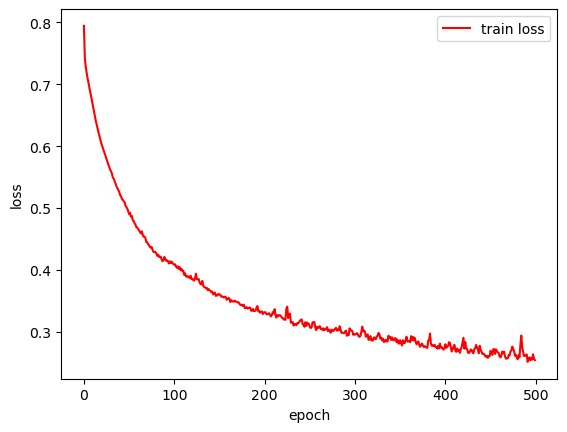

In [24]:

plt.plot(train_loss_list, label='train loss',color='red')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

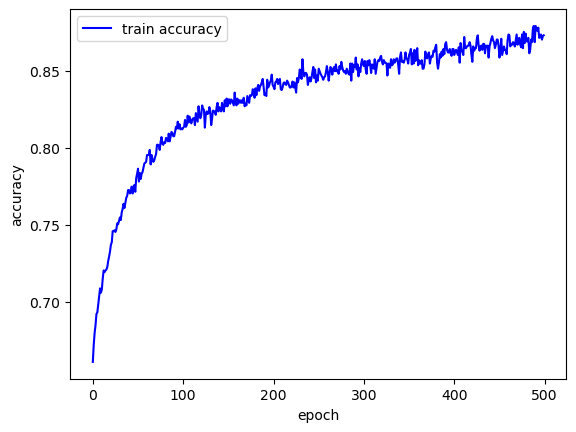

In [25]:
plt.plot(train_acc_list, label='train accuracy',color='blue')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion matrix

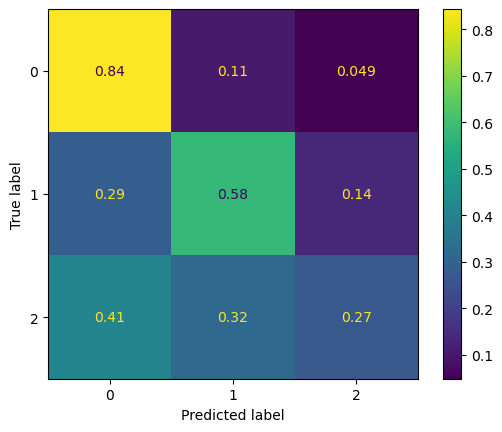

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, listarray)
cm = confusion_matrix(y_test, listarray, labels=[0,1,2],normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
disp.plot()
plt.show()

In [27]:
from sklearn.metrics import f1_score ## F1 Score 구하기
f1 = f1_score(y_test,listarray,pos_label='positive', average='micro')

C:\Users\Lab01\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [28]:
f1 

0.7283311772315654

### Auc

In [29]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [30]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# make sample data
n_classes = 3
# X, y = make_classification(n_samples=200, n_features=5,
#                            n_informative=3, n_redundant=2
#                            , n_clusters_per_class=2
#                            , n_classes=n_classes
#                            , weights=[0.3, 0.2, 0.5]
#                            , random_state=99)

# y = label_binarize(y, classes=[0,1,2])

# # split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# # classifier
# clf = OneVsRestClassifier(GaussianNB())
# clf.fit(X_train, y_train)
# y_score = clf.predict_proba(X_test)
#   # 나이브베이즈 모델은 predict_proba 메서드로 각 클래스별 probability를 구할 수 있습니다.

# ROC & AUC
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], listarray[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot of a ROC curve for a specific class
# plt.figure(figsize=(15, 5))
# for idx, i in enumerate(range(n_classes)):
#     plt.subplot(131+idx)
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Class %0.0f' % idx)
#     plt.legend(loc="lower right")
# plt.show()

print("roc_auc_score: ", multiclass_roc_auc_score(y_test, listarray))

roc_auc_score:  0.693584080121028
